In [1]:
import pandas as pd
import numpy as np

In [2]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import gridplot
import bokeh.palettes as bpal
from bokeh.models import CategoricalColorMapper
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import Legend
from bokeh.io import export_png
output_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [3]:
from glob import glob
from pprint import pprint
import dill
import json

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

<font color = 'purple'><font size = 5>
    A few functions used to shortcut displaying results<br>
    ================================================<br>

In [5]:
def output_CV(cv_array):     ## for use with bokeh.plotting imported
    pout = figure(plot_width = 300, plot_height = 200, y_range=(0,1)) 
    pout.circle(list(range(1, len(cv_array) +1)), cv_array, size=5)
    print('Mean CV score:  ', round(cv_array.mean(), 3))
    print('Std of CV scores:  ', round(cv_array.std(), 3))
    show(pout)

In [6]:
def give_gridsearch_results(ingridsrch_instance):
    print('Best score: ', round(ingridsrch_instance.best_score_, 3))
    print('Best params: ', ingridsrch_instance.best_params_)

In [7]:
def make_plotgrid(totalrange, ncols):
    """for feeding into bokeh griplot, returns array of rows/columns"""
    nrows = int(np.ceil(totalrange/ncols))
    feeder = iter(range(totalrange))
    plotgrid = [[]]*nrows
    for r in range(nrows):
        thisrow = []
        for c in range(ncols):
            try:
                thisrow.append(next(feeder))
            except:
                thisrow.append(None)
        plotgrid[r] = thisrow
    return plotgrid

In [8]:
make_plotgrid(12,3)

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11]]

In [9]:
def draw_gridplot(indf, columns='first', ncols=3, total_width=900, each_height=300, incolours = ['blue','red','yellow','green','purple','orange']):
    """Grid plots by month in bokeh
    Requires:
    > indf has datetime index
    > if columns are left unspecified (should be a list of col names), then just first column is plotted
    > only takes up to 6 columns, then runs out of colours to plot unless you put more into incolours"""
    if columns == 'first':
        columns = [indf.columns[0]]
    else:
        pass
    indf['Month'] = indf.index.month
    indf['mthname'] = indf.index.month_name()
    
    each_width = int(total_width/ncols)
    
    clrcols = [(col, clr) for col, clr in zip(columns, incolours)]
    dictmonth = {}
    
    for no,mth in enumerate(indf.mthname.unique()):
        dictmonth[no] = figure(plot_width=each_width, plot_height=each_height, title=mth, x_axis_type='datetime')
        for col, clr in clrcols:
            dictmonth[no].line(indf.index[indf.Month == no+1], indf[col][indf.Month == no+1], line_width=1, color = clr)
    
    plotgrid = make_plotgrid(len(indf.mthname.unique()), ncols=ncols)
    for row in range(len(plotgrid)):
        for p in range(len(plotgrid[row])):
            plotgrid[row][p] = dictmonth[plotgrid[row][p]]
    
    the_grid = gridplot(plotgrid)
    show(the_grid)
    return the_grid

<font color = 'purple'><font size = 5>
    getting data in<br>
    ================================================<br>

In [10]:
feat_files = glob('../data/ready-for-model/*.csv')
feat_files

['../data/ready-for-model/2009-18_NEMtotaldemand.csv',
 '../data/ready-for-model/20190226_SAdf_features.csv',
 '../data/ready-for-model/20190226_TASdf_features.csv',
 '../data/ready-for-model/20190226_NSWdf_features.csv',
 '../data/ready-for-model/20190226_VICdf_features.csv',
 '../data/ready-for-model/20190226_QLDdf_features.csv']

In [11]:
fildict = {f.split('_')[1][:-2] : {'fp' : f} for f in feat_files[1:]}

fildict

{'SA': {'fp': '../data/ready-for-model/20190226_SAdf_features.csv'},
 'TAS': {'fp': '../data/ready-for-model/20190226_TASdf_features.csv'},
 'NSW': {'fp': '../data/ready-for-model/20190226_NSWdf_features.csv'},
 'VIC': {'fp': '../data/ready-for-model/20190226_VICdf_features.csv'},
 'QLD': {'fp': '../data/ready-for-model/20190226_QLDdf_features.csv'}}

In [12]:
ftarget = feat_files[0]
ftarget

'../data/ready-for-model/2009-18_NEMtotaldemand.csv'

In [13]:
ndf = pd.DataFrame(index=[0,1], columns=['a','b'])
ndf   # If I'm going to put dfs in a dictionary I need a df I can call on to get .tabcompletes while typing code

,a,b
0,NaN,NaN
1,NaN,NaN


In [14]:
dfdict = {}
for region in fildict:
    dfdict[region] = pd.read_csv(fildict[region]['fp'], index_col=0, parse_dates=[0])

In [15]:
for region,df in dfdict.items():
    print(region, ' : ', df.isnull().sum().max())

SA  :  2640
TAS  :  432
NSW  :  3168
VIC  :  144
QLD  :  1344


In [16]:
for region,df in dfdict.items():
    print(region)
    print('------'*5)
    print(df.isnull().sum())
    print("======"*10)

SA
------------------------------
Date                                0
Hour_of_day                         0
Year                                0
shoulder                            0
summer                              0
winter                              0
workdaySA                           1
MOUNT-GAMBIER-AERO_MaxT_26021     288
ADELAIDE-AIRPORT_MinT_23034         0
MURRAY-BRIDGE_MinT_24584          672
PORT-AUGUSTA_MaxT_18201          2160
MOUNT-GAMBIER-AERO_MinT_26021     192
ADELAIDE-AIRPORT_MaxT_23034         0
MURRAY-BRIDGE_MaxT_24584          720
PORT-AUGUSTA_MinT_18201          2640
dtype: int64
TAS
------------------------------
Date                       0
Hour_of_day                0
Year                       0
shoulder                   0
summer                     0
winter                     0
workdayTAS                 1
HOBART_MinT_94029         48
LAUNCESTON_MaxT_91237    432
HOBART_MaxT_94029        192
LAUNCESTON_MinT_91237    240
dtype: int64
NSW
------------

In [17]:
dftarget = pd.read_csv(ftarget, index_col=0, parse_dates=[0])
dftarget.head()

,NSW1,QLD1,SA1,TAS1,VIC1,NEMtotal
SETTLEMENTDATE,,,,,,
2009-01-01 00:30:00,7535.00,5611.54,1310.89,909.71,4799.87,20167.01
2009-01-01 01:00:00,7229.24,5457.34,1272.69,896.63,4646.21,19502.11
2009-01-01 01:30:00,6857.62,5294.12,1178.87,897.52,4950.16,19178.29
2009-01-01 02:00:00,6535.05,5153.47,1130.78,906.22,4755.46,18480.98
2009-01-01 02:30:00,6287.88,5060.33,1059.53,893.19,4545.67,17846.60


In [18]:
for region, df in dfdict.items():
    y = dftarget[[region+'1']]
    dfdict[region] = pd.merge(df, y, how='inner', left_index=True, right_index=True).dropna()
    ## merge target with features to drop same rows where missing data exists, end up with 
    ## correctly corresponding indexes on features and target

<font color = 'purple'><font size = 4>
    Creating training and holdout test sets - pre-2018 and 2018 data respectively<br>
    =====================================================<br>

In [19]:
yraw = {}
dfYdict = {}
for region, df in dfdict.items():
    yraw[region] = df[region+'1']  ## holding onto unrounded data separately, just in case
    dfYdict[region] = np.ceil(df[region+'1']/5.0)*5.0
    # am going to round up targets to nearest multiple of 5 to reduce regression complexity
    dfdict[region] = df.drop(columns=['Date', region+'1'])

In [34]:
# print(len(Yvic.VIC1.unique()))
# print(len(Yvic.rVIC.unique()))
# print(f'reduced by factor of: {round(len(Yvic.VIC1.unique())/len(Yvic.rVIC.unique()))} !')

136957
1337
reduced by factor of: 102 !


In [20]:
Ytrains = {}
Ytests = {}

for region, yt in dfYdict.items():
    Ytrains[region] = yt[yt.index.year != 2018].copy()
    Ytests[region] = yt[yt.index.year == 2018].copy()

In [21]:
Xtrains = {}
Xtests = {}

for region, df in dfdict.items():
    Xtrains[region] = df[df.Year != 2018].astype(float).copy() # to avoid StandardScaler warnings about 
    Xtests[region] = df[df.Year == 2018].astype(float).copy()  # conversions to float filling up the page...

In [22]:
Xtests['SA'].head(3)

,Hour_of_day,Year,shoulder,summer,winter,workdaySA,MOUNT-GAMBIER-AERO_MaxT_26021,ADELAIDE-AIRPORT_MinT_23034,MURRAY-BRIDGE_MinT_24584,PORT-AUGUSTA_MaxT_18201,MOUNT-GAMBIER-AERO_MinT_26021,ADELAIDE-AIRPORT_MaxT_23034,MURRAY-BRIDGE_MaxT_24584,PORT-AUGUSTA_MinT_18201
SETTLEMENTDATE,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,2018.0,0.0,1.0,0.0,0.0,23.5,16.6,16.0,28.2,14.4,23.0,27.2,17.6
2018-01-01 00:30:00,0.5,2018.0,0.0,1.0,0.0,0.0,23.5,16.6,16.0,28.2,14.4,23.0,27.2,17.6
2018-01-01 01:00:00,1.0,2018.0,0.0,1.0,0.0,0.0,23.5,16.6,16.0,28.2,14.4,23.0,27.2,17.6


In [ ]:
# shufs = ShuffleSplit(test_size=0.3, random_state=307132)

In [ ]:
# stscaler = StandardScaler()

<font color = 'purple'><font size = 5>
    K-Nearest Neighbours<br>
    =====================================================<br>

In [48]:
kgrid_params = {'knn__n_neighbors' : [3,5,7,9],
               'knn__weights' : ['distance'],     # in previous gridsearches, distance and minkowski
               'knn__metric' : ['minkowski']}     # consistently came out as best

In [49]:
# kgdict = {k: GridSearchCV(Pipeline(steps=[('stsc', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))]), 
#                           param_grid=kgrid_params, n_jobs=-1, cv = 9) for k in dfdict.keys()}
# ## dict of KNN gridsearch instantiations

In [78]:
# kgresults = {r : {k:v for k,v in zip(['params','mean_test_score','std_test_score', 'rank_test_score'], [None]*4)} 
#              for r in dfdict.keys()}
# # kgresults

In [56]:
# %%time
# for region in kgdict.keys():
#     kgdict[region].fit(Xtrains[region], Ytrains[region])
#     results = kgdict[region].cv_results_
    
#     kgresults[region]['params'] = results['params']
#     kgresults[region]['mean_test_score'] = results['mean_test_score']
#     kgresults[region]['std_test_score'] = results['std_test_score']
#     kgresults[region]['rank_test_score'] = results['rank_test_score']

CPU times: user 2.87 s, sys: 721 ms, total: 3.59 s
Wall time: 11min 4s


In [60]:
# with open('./pickles/fitted_KNN_gridsearchs.pickle', 'wb') as outfile:
#     dill.dump(kgdict, outfile)

In [71]:
# with open('./pickles/knngridsrch_results.pickle', 'wb') as outfile:
#     dill.dump(kgresults, outfile)

In [24]:
with open('./pickles/knngridsrch_results.pickle', 'rb') as infile:
    kgresults = dill.load(infile)

In [26]:
kgdmeans = pd.DataFrame(columns=kgresults.keys(), index=[3,5,7,9])

for k in kgresults.keys():
    kgdmeans[k] = kgresults[k]['mean_test_score']
kgdmeans

,SA,TAS,NSW,VIC,QLD
3,0.691972,0.565167,0.813237,0.779872,0.845694
5,0.692531,0.578873,0.810537,0.779545,0.841860
7,0.689948,0.588943,0.801292,0.776952,0.834332
9,0.688650,0.600610,0.787376,0.773551,0.826714


In [27]:
kgdvar = pd.DataFrame(columns=kgresults.keys(), index=[3,5,7,9])

for k in kgresults.keys():
    kgdvar[k] = kgresults[k]['std_test_score']
kgdvar

,SA,TAS,NSW,VIC,QLD
3,0.048594,0.086959,0.034355,0.030904,0.044821
5,0.047587,0.086612,0.033180,0.031497,0.044403
7,0.046275,0.086941,0.032557,0.032103,0.043903
9,0.044360,0.086936,0.031400,0.032408,0.043054


In [34]:
kgdrank = pd.DataFrame(columns=kgresults.keys(), index=[3,5,7,9])

for k in kgresults.keys():
    kgdrank[k] = kgresults[k]['rank_test_score']
kgdrank

,SA,TAS,NSW,VIC,QLD
3,2,4,1,1,1
5,1,3,2,2,2
7,3,2,3,3,3
9,4,1,4,4,4


In [29]:
bcolors_10 = bpal.Category20_10
print(bcolors_10)

['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']


In [30]:
bcolors_bold5 = bcolors_10[::2]
bcolors_bold5

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

In [33]:
nem_region_cmap = {k:v for k,v in zip(dfdict.keys(), bcolors_bold5)}
nem_region_cmap

{'SA': '#1f77b4',
 'TAS': '#ff7f0e',
 'NSW': '#2ca02c',
 'VIC': '#d62728',
 'QLD': '#9467bd'}

In [36]:
pw = 300
ph = 300

kmfig = figure(plot_height = ph, plot_width = 310, title='Mean', y_range=(0,1))
kvfig = figure(plot_height = ph, plot_width = 400, title='Var', y_range=(0,0.1))
krfig = figure(plot_height = ph, plot_width = 400, title='Rank')
legend = []
for region in kgdmeans.columns:
    kmfig.line(kgdmeans.index, kgdmeans[region], line_color=nem_region_cmap[region], )
    kvfig.line(kgdvar.index, kgdvar[region], line_color=nem_region_cmap[region])
    r = krfig.line(kgdrank.index, kgdrank[region], line_color=nem_region_cmap[region])
    legend.append((region, [r]))

legend = Legend(items=legend, location=(15, 120))

krfig.add_layout(legend, 'right')

kplotgrid = gridplot([kmfig, kvfig, krfig], ncols=2)
show(kplotgrid)
export_png(kplotgrid, filename='../charts_out/knn-gridsearch-results.png')

'/Users/pat.hearps/Documents/DataScienceStudy/General Assembly/Capstone_working/elec-forecast-nem-g/Elec/modelling-analysis/knn-gridsearch-results.png'

In [37]:
knnbestd = {k: Pipeline(steps=[('stsc', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=9, weights='distance', metric='minkowski', n_jobs=-1))]) for k in dfdict.keys()}

In [38]:
for region in knnbestd.keys():
    knnbestd[region].fit(Xtrains[region], Ytrains[region])

In [39]:
kpredicts = pd.DataFrame()
kpredicts

""


In [40]:
for region in knnbestd.keys():
    df = pd.DataFrame(index=Xtests[region].index, data=knnbestd[region].predict(Xtests[region]), columns=[region])
    kpredicts = pd.merge(kpredicts, df, how='outer', left_index=True, right_index=True)

In [41]:
kpredicts.head()

,SA,TAS,NSW,VIC,QLD
SETTLEMENTDATE,,,,,
2018-01-01 00:00:00,1233.665189,989.416223,NaN,4278.837368,5771.005415
2018-01-01 00:30:00,1211.365858,995.899590,NaN,4276.596299,5769.401743
2018-01-01 01:00:00,1209.026647,997.304112,NaN,4167.538114,5767.722682
2018-01-01 01:30:00,1206.542083,998.308206,NaN,4065.386278,5765.997989
2018-01-01 02:00:00,1203.993306,997.709801,NaN,4020.176005,5764.259920


In [42]:
kpredicts.isnull().any(axis=1).sum() / len(kpredicts)
# so 15% of the year we are missing at least one of the values from the NEM regions

0.15616438356164383

In [43]:
kpredicts.isnull().sum() / len(kpredicts)
# but individually there are only single-digit percentages missing from each NEM region

SA     0.019178
TAS    0.013699
NSW    0.035616
VIC    0.002740
QLD    0.093151
dtype: float64

In [44]:
kbresults = pd.DataFrame(index=dftarget.index[dftarget.index.year == 2018])

for region in kpredicts.columns:
    df = pd.merge(dftarget[[region+'1']], kpredicts[[region]].dropna(), how='inner', left_index=True, right_index=True)
    kbresults = pd.merge(kbresults, df, how='outer', left_index=True, right_index=True)

df = pd.DataFrame(kpredicts.dropna().sum(axis=1), columns=['NEMpred'])
df = pd.merge(dftarget[['NEMtotal']], df, how='inner', left_index=True, right_index=True)
kbresults = pd.merge(kbresults, df, how='outer', left_index=True, right_index=True)

kbresults.rename(columns={k:k+'pred' for k in kbresults.columns if '1' not in k and len(k) < 4}, inplace=True)
kbresults.rename(columns={'NEMtotal':'NEM1'}, inplace=True)
kbresults['Ntot_err'] = kbresults.NEM1 - kbresults.NEMpred
kbresults.head()
# creates merged results dataframe with only NaN where is missing from each particular region
# but NEM totals only where we have a value for every region

,SA1,SApred,TAS1,TASpred,NSW1,NSWpred,VIC1,VICpred,QLD1,QLDpred,NEM1,NEMpred,Ntot_err
SETTLEMENTDATE,,,,,,,,,,,,,
2018-01-01 00:00:00,1359.47,1233.665189,989.02,989.416223,NaN,NaN,4445.07,4278.837368,6210.63,5771.005415,NaN,NaN,NaN
2018-01-01 00:30:00,1289.10,1211.365858,982.07,995.899590,NaN,NaN,4251.18,4276.596299,6030.84,5769.401743,NaN,NaN,NaN
2018-01-01 01:00:00,1242.28,1209.026647,979.69,997.304112,NaN,NaN,4092.53,4167.538114,5931.49,5767.722682,NaN,NaN,NaN
2018-01-01 01:30:00,1156.19,1206.542083,961.96,998.308206,NaN,NaN,3958.95,4065.386278,5875.22,5765.997989,NaN,NaN,NaN
2018-01-01 02:00:00,1112.46,1203.993306,950.80,997.709801,NaN,NaN,3785.27,4020.176005,5806.38,5764.259920,NaN,NaN,NaN


In [45]:
kbscores = {k:v for k,v in zip([d.split('1')[0][:3] for d in dftarget.columns], [None]*6)}
kbscores

{'NSW': None, 'QLD': None, 'SA': None, 'TAS': None, 'VIC': None, 'NEM': None}

In [46]:
r2_score(kbresults['QLD1'].dropna(), kbresults['QLDpred'].dropna())

0.8300562890785571

In [47]:
for region in kbscores.keys():
    kbscores[region] = round(r2_score(kbresults[region+'1'].dropna(), kbresults[region+'pred'].dropna()),2)
kbscores

{'NSW': 0.81, 'QLD': 0.83, 'SA': 0.61, 'TAS': 0.61, 'VIC': 0.76, 'NEM': 0.86}

In [48]:
draw_gridplot(kbresults, columns=['NEM1', 'NEMpred'])

Column(id='2852', ...)

In [49]:
kbresults['pos_err'] = kbresults.Ntot_err.apply(lambda x: x if x >= 0 else np.NaN)
kbresults['neg_err'] = kbresults.Ntot_err.apply(lambda x: x if x < 0 else np.NaN)
kbresults.head(2)

,SA1,SApred,TAS1,TASpred,NSW1,NSWpred,VIC1,VICpred,QLD1,QLDpred,NEM1,NEMpred,Ntot_err,Month,mthname,pos_err,neg_err
SETTLEMENTDATE,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,1359.47,1233.665189,989.02,989.416223,NaN,NaN,4445.07,4278.837368,6210.63,5771.005415,NaN,NaN,NaN,1,January,NaN,NaN
2018-01-01 00:30:00,1289.10,1211.365858,982.07,995.899590,NaN,NaN,4251.18,4276.596299,6030.84,5769.401743,NaN,NaN,NaN,1,January,NaN,NaN


In [50]:
posneg = draw_gridplot(kbresults, ncols=4, each_height=200, columns=['pos_err','neg_err'], incolours=['green','maroon'])
export_png(posneg, 'pos-neg-error-NEMtotal.png')

'/Users/pat.hearps/Documents/DataScienceStudy/General Assembly/Capstone_working/elec-forecast-nem-g/Elec/modelling-analysis/pos-neg-error-NEMtotal.png'

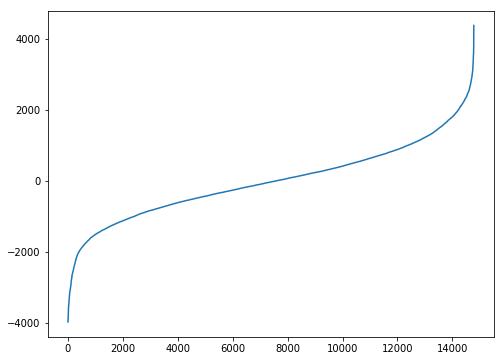

In [51]:
kbresults.Ntot_err.sort_values().reset_index(drop=True).plot(figsize=(8,6))
plt.savefig('knn-NEMtotal-sortederror.png')

In [53]:
# with open('knn-results-dataframe.pickle', 'wb') as outfile:
#     dill.dump(kbresults, outfile)

In [52]:
draw_gridplot(kbresults[abs(kbresults.Ntot_err) > 2000], ncols=4, each_height=200, columns=['pos_err','neg_err'], incolours=['green','maroon'])

/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/pat.hearps/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Column(id='10957', ...)

<font color = 'purple'><font size = 5>
    Decision Tree<br>
    =====================================================<br>

In [53]:
# treebeard = DecisionTreeRegressor()

In [225]:
# %%time
# dtscore = cross_val_score(treebeard, Xvic, Yvic.rVIC, n_jobs=-1, cv=9)

In [226]:
# output_CV(dtscore)

In [56]:
# dtparams = {'max_depth' : [None, 15, 30, 50],
#            'min_samples_split' : [2, 6, 12, 24],
#            'min_samples_leaf' : [1, 5, 10],
#            }

In [57]:
# dtgridsrch = GridSearchCV(treebeard, param_grid=dtparams, cv=9, n_jobs=-1)

In [227]:
# %%time
# dtgridsrch.fit(Xvic, Yvic.rVIC)

In [228]:
# give_gridsearch_results(dtgridsrch)

In [229]:
# trbest = dtgridsrch.best_estimator_

In [230]:
# %%time
# dtcvscore = cross_val_score(trbest, Xvic, Yvic.rVIC, cv=9, n_jobs=-1)

In [231]:
# output_CV(dtcvscore)

In [232]:
# hoYvic['bestDtree'] = trbest.predict(hoXvic)
# hoYvic.head(3)

In [233]:
# draw_gridplot(hoYvic, columns=['VIC1','bestDtree'])

In [ ]:
# treebeard.fit(Xvic, Yvic)
# treebeard.score(hoXvic, hoYvic.VIC1)

In [ ]:
# hoYvic['dtree_pred'] = treebeard.predict(hoXvic)

In [ ]:
# draw_gridplot(hoYvic, columns=['VIC1','dtree_pred'])

In [82]:
# dot_data = StringIO()    # this keeps on giving massive files, I think regression tree is too complex?

# export_graphviz(trbest, out_file='treebeard.dot',  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = Xvic.columns)  

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [234]:
# trbest

In [77]:
# from subprocess import call

In [235]:
# %%time          ## also doesn't seem to work properly
# call(['dot', '-Tpng', 'treebeard.dot', '-o', 'treebeard.png', '-Gdpi=600']) 